# Setup with Conda
First install the libmamba solver for Conda
```sh
    conda update -n base conda
    conda install -n base conda-libmamba-solver
    conda config --set solver libmamba
```

Next create a new Conda Environment with the instances
```sh
    conda create --solver=libmamba -n rapids-23.10 -c rapidsai -c conda-forge -c nvidia  \
    rapids=23.10 python=3.10 cuda-version=12.0
```

Finally install pip 
```sh
    conda install pip
```

Use pip to install any other missing packages/modules for this notebook

In [8]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from os import listdir
from numpy import load
from numpy import asarray
from numpy import savez_compressed
# from keras.models import load_model
from keras_facenet import FaceNet
# from mtcnn.mtcnn import MTCNN
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import Normalizer
# from sklearn.metrics import accuracy_score
# from cuml import KMeans
from cuml.cluster import KMeans
from cuml.metrics.accuracy import accuracy_score
from cuml.dask.preprocessing.LabelEncoder import LabelEncoder
import cudf
import pandas as pd
import re

USE_CUDA = True

if (USE_CUDA):
    device = 'cuda:0'
else:
    device = 'cpu'

torch.Size([3, 160, 160])

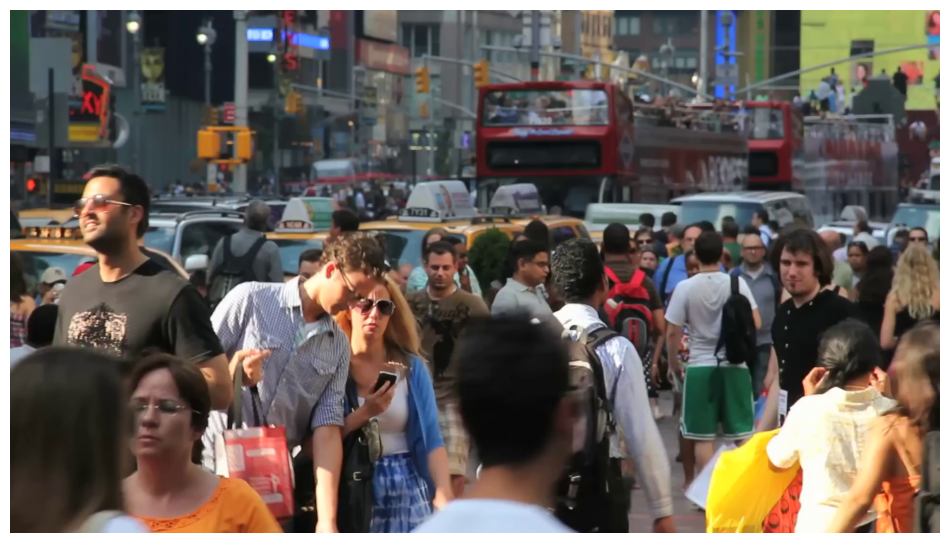

In [ ]:
# Create face detector
mtcnn = MTCNN(select_largest=False, device=device)

# Load a single image and display
v_cap = cv2.VideoCapture('../videoplayback.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

# Detect face
face = mtcnn(frame)
face.shape

(-0.5, 159.5, 159.5, -0.5)

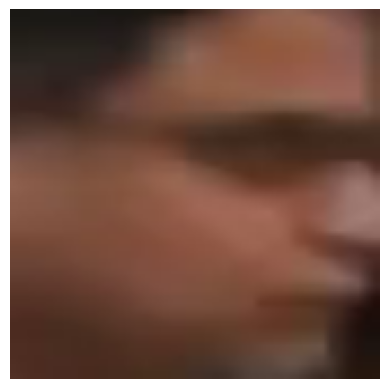

In [ ]:
# Create face detector
mtcnn = MTCNN(select_largest=False, post_process=False, device=device)

# Detect face
face = mtcnn(frame)

# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off')

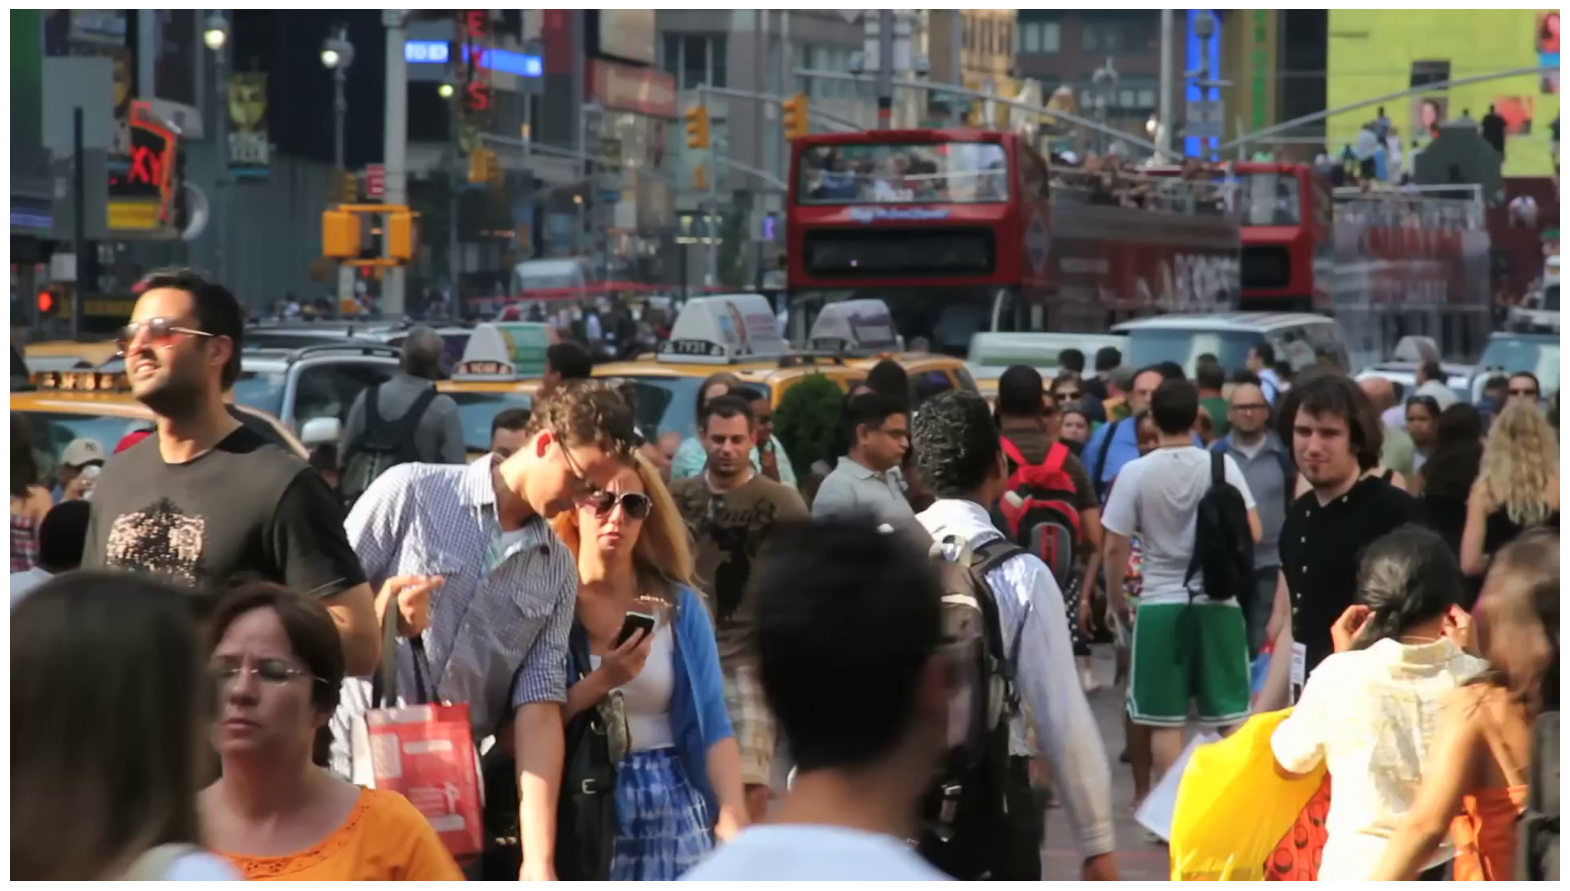

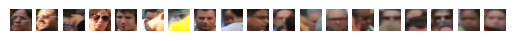

In [9]:
# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device=device)

# Load a single image and display
v_cap = cv2.VideoCapture('../videoplayback.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(20,20))
plt.imshow(frame)
plt.axis('off')
plt.show()

# Detect face
faces = mtcnn(frame)

# print("Type of faces: {}".format(faces[0]))

# Visualize
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()

In [ ]:
face_data = np.zeros(faces[0].permute(1,2,0).int().numpy().shape, dtype=np.uint8)
face_data[:,:,:] = np.uint8(faces[0].permute(1,2,0).int().numpy()[:,:,:])
# face_data = faces[0].permute(1,2,0).int().numpy().view('int8')
print("Type of facedata: {} with shape {} and dtype {}".format(type(face_data), face_data.shape, face_data.dtype))
face_img = Image.fromarray(face_data)
face_img.save("../test_img.png")

Type of facedata: <class 'numpy.ndarray'> with shape (160, 160, 3) and dtype uint8


In [10]:
# # extracts faces from entire LFW dataset using MTCNN
preprocessing_file = '../mtcnn_extracted_faces/'
from_file = '../LFW_Dataset/lfw-deepfunneled/lfw-deepfunneled/'

list_directories = os.listdir(from_file)
for dir in list_directories:
  curr_path = from_file + dir
  curr_files = [curr_path + '/' + image for image in os.listdir(curr_path)]

  for i, curr_img in enumerate(curr_files):
    frame = Image.open(curr_img).convert("RGB")
    faces = mtcnn(frame)

    if faces is None:
      continue

    # convert faces into a PIL image array
    pil_images = []
    for face in faces:
        pil_images.append(Image.fromarray(np.uint8(face.permute(1,2,0).int().numpy())))

    save_path = preprocessing_file + dir + '/'
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    
    for img in pil_images:
      save_name = save_path + dir + str(i).zfill(4) + '.jpg'
      # print("saving file: {}".format(save_name))
      img.save(save_name)


In [12]:
# resize the extracted faces from the previous step
root_dir = '../mtcnn_extracted_faces/'
new_save_dir = '../mtcnn_extracted_faces_resize_50_50/'

show_first = True
for sub_dir in listdir(root_dir):

    full_sub_dir_path = root_dir + sub_dir + '/'
    for img_name in listdir(full_sub_dir_path):
        
        curr_img_path = full_sub_dir_path + img_name
        frame = Image.open(curr_img_path).convert("RGB")
        if show_first:
            print(f"Shape first image {frame.size}")
            show_first = False
        frame = ImageOps.grayscale(frame.resize((50,50)))

        curr_save_path = new_save_dir + sub_dir + '/'

        if not os.path.exists(curr_save_path):
            os.makedirs(curr_save_path)

        frame.save(curr_save_path + img_name)

Shape first image (160, 160)


In [13]:
# def extract_image(image):
#   img1 = Image.open(image)
#   img1 = img1.convert('RGB')
#   pixels = asarray(img1)
#   detector = MTCNN()
#   f = detector.detect_faces(pixels)
#   x1,y1,w,h = f[0]['box']
#   x1, y1 = abs(x1), abs(y1)
#   x2 = abs(x1+w)
#   y2 = abs(y1+h)
#   #locate the co-ordinates of face in the image
#   store_face = pixels[y1:y2,x1:x2]
#   # plt.imshow(store_face)
#   image1 = Image.fromarray(store_face,'RGB')
#   image1 = image1.resize((160,160))
#   face_array = asarray(image1)
#   return face_array


# def load_faces(directory):
#   face = []
#   for filename in listdir(directory):
#     path = directory + filename
#     faces = extract_image(path)
#     face.append(faces)
#   return face


def load_dataset(directory, batch_size=1000):
  train_x, train_y, test_x, test_y = [],[], [],[]
  batch_num = 0

  # add slash to end of dir path
  if directory[-1] != '/':
    directory += '/'

  with open('targetnames.txt', 'w') as file:

    for i, subdir in enumerate(sorted(listdir(directory))):

      if ((i % batch_size) == 0) and i != 0:
        savez_compressed('lfw-deepfunneled-dataset_{}.npz'.format(str(batch_num).zfill(4)),train_x,train_y,test_x,test_y)

        train_x, train_y, test_x, test_y = [],[], [],[]
        batch_num += 1

      path = directory + subdir + '/'
      #load all faces in subdirectory
      faces = [asarray(Image.open(path + img_name).convert("L")) for img_name in listdir(path)]
      if len(faces)>1:
        test_x.append(faces.pop())
        test_y.append(i)
      # labels = [subdir for _ in range(len(faces))]
      # print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
      train_x.extend(faces)
      train_y.extend([i for _ in range(len(faces))])
      file.write(subdir + '\n')
    # return asarray(train_x),asarray(train_y), asarray(test_x), asarray(test_y)

    if not (train_x == [] and train_y == [] and test_x == [] and test_y == []):
      savez_compressed('lfw-deepfunneled-dataset_{}.npz'.format(str(batch_num).zfill(4)),train_x,train_y,test_x,test_y)


load_dataset('../mtcnn_extracted_faces_resize_50_50/', 1000)

In [ ]:
#create and save embeddings
embedder = FaceNet()
#load the compressed dataset and facenet keras model
dataset_npz_filenames = []
reg_expr = '^lfw-deepfunneled-dataset_[0-9]{4}.npz'
for file in listdir('./'):
    if re.search(reg_expr, file):
        dataset_npz_filenames.append(file)

print(dataset_npz_filenames)
new_trainx = new_testx = np.zeros((0,512), dtype='float32')
for i, file in enumerate(dataset_npz_filenames):
    data = load(file)
    trainx, testx = data['arr_0'],data['arr_2']
    print(trainx.shape, testx.shape)

    new_trainx = np.vstack((new_trainx, embedder.embeddings(trainx)))
    new_testx = np.vstack((new_testx, embedder.embeddings(testx)))
    print('new_trainx {} | new_testx {} | dtype {}'.format(new_trainx.shape, new_testx.shape, new_testx.dtype))

#save the embeddings
#compress the 128 embeddings of each face
print("Final new_trainx size {} | Final new_testx size {}".format(new_trainx.shape, new_testx.shape))
savez_compressed('lfw-deepfunneled-embeddings_200.npz',new_trainx,new_testx)

2023-12-10 18:18:32.741649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 18:18:32.742181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 18:18:32.742296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

['lfw-deepfunneled-dataset_0002.npz', 'lfw-deepfunneled-dataset_0003.npz', 'lfw-deepfunneled-dataset_0000.npz', 'lfw-deepfunneled-dataset_0005.npz', 'lfw-deepfunneled-dataset_0004.npz', 'lfw-deepfunneled-dataset_0001.npz']
(1737, 160, 160, 3) (278, 160, 160, 3)


2023-12-10 18:18:42.158814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-10 18:18:42.170466: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:504] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.2
  /usr/local/cuda
  /home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2023-12-10 18:18:42.170497: W exte

UnknownError: Graph execution error:

Detected at node inception_resnet_v1/Bottleneck_BatchNorm/batchnorm/Rsqrt defined at (most recent call last):
  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_12688/3869121294.py", line 17, in <module>

  File "/home/jorgejc2/.local/lib/python3.10/site-packages/keras_facenet/__init__.py", line 113, in embeddings

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/jorgejc2/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 788, in call

JIT compilation failed.
	 [[{{node inception_resnet_v1/Bottleneck_BatchNorm/batchnorm/Rsqrt}}]] [Op:__inference_predict_function_9375]

In [ ]:
def np2cudf(df):
    # convert numpy array to cuDF dataframe
    df = pd.DataFrame({'fea%d'%i:df[:,i] for i in range(df.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
        pdf[str(c)] = df[column]
    return pdf

In [ ]:
# Load the compressed dataset and embeddings
data = np.load('./lfw-deepfunneled-embeddings_200.npz')
train_X, test_X = data['arr_0'], data['arr_1']

# Load true labels from the original dataset
train_Y = test_Y = []
dataset_npz_filenames = []
reg_expr = '^lfw-deepfunneled-dataset_[0-9]{4}.npz'
for file in listdir('./'):
    if re.search(reg_expr, file):
        dataset_npz_filenames.append(file)
for i, filename in enumerate(dataset_npz_filenames):
    original_data = np.load(filename)
    for el in original_data['arr_1']:
        train_Y.append(el)
    for el in original_data['arr_3']:
        test_Y.append(el)
    # train_Y, test_Y = original_data['arr_1'], original_data['arr_3']

# Flatten the embeddings to make them 2D
train_X_flat = train_X.reshape((train_X.shape[0], -1))
test_X_flat = test_X.reshape((test_X.shape[0], -1))

# Apply k-means clustering
k = len(np.unique(train_Y))  # Number of clusters is set to the number of unique labels in the dataset
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(np2cudf(train_X_flat))

with np.printoptions(threshold=np.inf):
    print("labels:")
    print(kmeans.labels_)
    print("cluster_centers:")
    print(kmeans.cluster_centers_)

# Predict clusters on the test set
test_clusters = kmeans.predict(test_X_flat)

# Convert true labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(test_Y)

# Evaluate clustering performance
accuracy = accuracy_score(true_labels_encoded, test_clusters)

print(f'Clustering Accuracy: {accuracy}')

labels:
0         420
1         614
2         420
3        3424
4        2496
         ... 
11548    3150
11549    5200
11550    1577
11551    1577
11552    1481
Length: 11553, dtype: int32
cluster_centers:
           0         1         2         3         4         5         6    \
0    -0.030084  0.013313  0.010641  0.018066  0.005711  0.123841 -0.064975   
1     0.040802 -0.030596 -0.027078 -0.001514 -0.035035 -0.110265 -0.011290   
2     0.063079  0.067805 -0.071489 -0.043344 -0.009107  0.004324 -0.010087   
3     0.077692  0.034965 -0.000576  0.025645 -0.017561  0.034271 -0.029822   
4     0.134729 -0.023052  0.045306 -0.003971 -0.067478 -0.045568 -0.085323   
...        ...       ...       ...       ...       ...       ...       ...   
5744  0.025699  0.034139 -0.055657 -0.013032  0.081212  0.026734 -0.022416   
5745  0.084324  0.008662 -0.097879 -0.066954 -0.074353 -0.034857  0.043660   
5746  0.031978  0.021105  0.098520 -0.012971 -0.012604  0.055996 -0.012515   
5747  0.06124

ValueError: No clients found
Start a client and point it to the scheduler address
  from distributed import Client
  client = Client('ip-addr-of-scheduler:8786')


In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from os import listdir
from numpy import load
from numpy import asarray
from numpy import savez_compressed
from sklearn.preprocessing import StandardScaler as StandardScaler_C
from sklearn.preprocessing import MinMaxScaler as MinMaxScaler_C
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier_C
from sklearn.preprocessing import LabelEncoder as LabelEncoder_C
from sklearn import metrics as metrics_C
# from keras.models import load_model
from keras_facenet import FaceNet
# from mtcnn.mtcnn import MTCNN
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import Normalizer
# from sklearn.metrics import accuracy_score
# from cuml import KMeans
from cuml.cluster import KMeans
from cuml.metrics.accuracy import accuracy_score
#from cuml.dask.preprocessing.LabelEncoder import LabelEncoder
from cuml.preprocessing import LabelEncoder
from cuml.svm import LinearSVC
from cuml.preprocessing import Normalizer
import cudf
import cupy as cp
import pandas as pd
import re

from pca_class import LFW_IncrementalPCA

USE_CUDA = True

if (USE_CUDA):
    device = 'cuda:0'
else:
    device = 'cpu'

2023-12-14 17:21:12.373169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 17:21:12.410725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 17:21:12.410758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 17:21:12.411535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 17:21:12.417054: I tensorflow/core/platform/cpu_feature_guar

In [3]:
def load_dataset(directory, batch_size=1000):
  train_x, train_y, test_x, test_y = [],[], [],[]
  batch_num = 0

  # add slash to end of dir path
  if directory[-1] != '/':
    directory += '/'

  with open('targetnames.txt', 'w') as file:

    for i, subdir in enumerate(sorted(listdir(directory))):

      if ((i % batch_size) == 0) and i != 0:
        savez_compressed('lfw-deepfunneled-dataset_{}.npz'.format(str(batch_num).zfill(4)),train_x,train_y,test_x,test_y)

        train_x, train_y, test_x, test_y = [],[], [],[]
        batch_num += 1

      path = directory + subdir + '/'
      #load all faces in subdirectory
      faces = [asarray(Image.open(path + img_name).convert("RGB")) for img_name in listdir(path)]
      if len(faces)>1:
        test_x.append(faces.pop())
        test_y.append(subdir)
      labels = [subdir for _ in range(len(faces))]
      # print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
      train_x.extend(faces)
      train_y.extend(labels)
      file.write(subdir + '\n')
    # return asarray(train_x),asarray(train_y), asarray(test_x), asarray(test_y)

    if not (train_x == [] and train_y == [] and test_x == [] and test_y == []):
      savez_compressed('lfw-deepfunneled-dataset_{}.npz'.format(str(batch_num).zfill(4)),train_x,train_y,test_x,test_y)


load_dataset('../mtcnn_extracted_faces/')

In [4]:
# create embeddings
n_components = 512
dataset_npz_filenames = []
reg_expr = '^lfw-deepfunneled-dataset_[0-9]{4}.npz'
for file in listdir('./'):
    if re.search(reg_expr, file):
        dataset_npz_filenames.append(file)
dataset_npz_filenames = sorted(dataset_npz_filenames)
print(dataset_npz_filenames)
# create an lfw_ipca instance and give the label of datasets and desired n_componentes
lfw_ipca = LFW_IncrementalPCA(dataset_npz_filenames, n_components=n_components)

# start the fit on the entire datasets given 
lfw_ipca.start_fit(display_progress=True)

# save the embeddings as a compressed .npz file
lfw_ipca.save_embeddings("lfw-deepfunneled-pca-embeddings-50.npz", display_progress=True)

['lfw-deepfunneled-dataset_0000.npz', 'lfw-deepfunneled-dataset_0001.npz', 'lfw-deepfunneled-dataset_0002.npz', 'lfw-deepfunneled-dataset_0003.npz', 'lfw-deepfunneled-dataset_0004.npz', 'lfw-deepfunneled-dataset_0005.npz']
(0, lfw-deepfunneled-dataset_0000.npz | X_train.shape (1806, 160, 160, 3))
i = 0 | Partial fit on X_train of sizes (1806, 76800)
(1, lfw-deepfunneled-dataset_0001.npz | X_train.shape (2530, 160, 160, 3))
i = 1 | Partial fit on X_train of sizes (2530, 76800)


In [ ]:
# Load the compressed dataset and embeddings
data = np.load('./lfw-deepfunneled-pca-embeddings-50.npz')
train_X, train_Y, test_X, test_Y = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [ ]:
#Linear SVC Results

model=LinearSVC(C=10)

#MinMaxScaling
scaler=MinMaxScaler_C().fit(train_X)
trainx =scaler.transform(train_X)
testx = scaler.transform(test_X)

#encode labels
label_encoder = LabelEncoder().fit(train_Y)
true_training_labels_encoded = label_encoder.transform(train_Y)

model.fit(cp.asarray(trainx),cp.asarray(true_training_labels_encoded))


#predict
predict_train = model.predict(cp.asarray(trainx))
predict_test = model.predict(cp.asarray(testx))

#Accuracy
true_test_labels_encoded = label_encoder.transform(test_Y)
acc_train = accuracy_score(true_training_labels_encoded,predict_train)
acc_test = accuracy_score(true_test_labels_encoded,predict_test)


print(acc_train)
print(acc_test)
